In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

In this tutorial, I will describe a hack that let's us use [PyMC3](http://docs.pymc.io/) to sample a probability density defined using [TensorFlow](https://www.tensorflow.org/).
This isn't necessarily a Good Idea™, but I've found it useful for a few projects so I wanted to share the method.
To start, I'll try to motivate why I decided to attempt this mashup, and then I'll give a simple example to demonstrate how you might use this technique in your own work.

## Why TensorFlow?

I recently started using TensorFlow as a framework for probabilistic modeling (and [encouraging other astronomers to do the same](https://speakerdeck.com/dfm/tensorflow-for-astronomers)) because the API seemed stable and it was relatively easy to extend the language with custom operations written in C++.
This second point is crucial in astronomy because we often want to fit realistic, physically motivated models to our data, and it can be inefficient to implement these algorithms within the confines of existing probabilistic programming languages.
To this end, I have been working on developing various custom operations within TensorFlow to implement [scalable Gaussian processes](https://github.com/dfm/celeriteflow) and [various special functions for fitting exoplanet data (Foreman-Mackey et al., in prep, ha!)](https://github.com/dfm/exoplanet).
These experiments have yielded promising results, but my ultimate goal has always been to combine these models with [Hamiltonian Monte Carlo](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo) sampling to perform posterior inference.
I don't know of any Python packages with the capabilities of projects like PyMC3 or [Stan](http://mc-stan.org/) that support TensorFlow out of the box.
I know that [Edward](http://edwardlib.org/)/[TensorFlow probability](https://github.com/tensorflow/probability) has an HMC sampler, but it does not have a NUTS implementation, tuning heuristics, or any of the other niceties that the MCMC-first libraries provide.

## Why HMC?

The benefit of HMC compared to some other MCMC methods (including [one that I wrote](http://emcee.readthedocs.io/en/stable/)) is that it is substantially more efficient (i.e. requires less computation time per independent sample) for models with large numbers of parameters.
To achieve this efficiency, the sampler uses the gradient of the log probability function with respect to the parameters to generate good proposals.
This means that it must be possible to compute the first derivative of your model with respect to the input parameters.
To do this in a user-friendly way, most popular inference libraries provide a modeling framework that users must use to implement their model and then the code can [automatically compute these derivatives](https://en.wikipedia.org/wiki/Automatic_differentiation).

## Why PyMC3?

As far as I can tell, there are two popular libraries for HMC inference in Python: [PyMC3](http://docs.pymc.io/) and [Stan](http://mc-stan.org/) (via the [pystan](http://pystan.readthedocs.io/en/latest/) interface).
I have previously blogged about [extending Stan using custom C++ code and a forked version of pystan](https://dfm.io/posts/stan-c++/), but I haven't actually been able to use this method for my research because debugging any code more complicated than the one in that example ended up being far too tedious.
Furthermore, since I generally want to do my initial tests and make my plots in Python, I always ended up implementing two version of my model (one in Stan and one in Python) and it was frustrating to make sure that these always gave the same results.
PyMC3 is much more appealing to me because the models are actually Python objects so you can use the same implementation for sampling and pre/post-processing.
The catch with PyMC3 is that you must be able to evaluate your model within the [Theano](http://deeplearning.net/software/theano/) framework and I wasn't so keen to learn Theano when I had already invested a substantial amount of time into TensorFlow and [since Theano has been deprecated](https://groups.google.com/forum/#!msg/theano-users/7Poq8BZutbY/rNCIfvAEAwAJ) as a general purpose modeling language.
What I *really* want is a sampling engine that does all the tuning like PyMC3/Stan, but without requiring the use of a specific modeling framework.
I imagine that this interface would accept two Python functions (one that evaluates the log probability, and one that evaluates its gradient) and then the user could choose whichever modeling stack they want.
That being said, my dream sampler doesn't exist (despite [my weak attempt](https://github.com/dfm/hemcee) to start developing it) so I decided to see if I could hack PyMC3 to do what I wanted.

## The TensorFlow + Theano mashup

To get started on implementing this, I reached out to [Thomas Wiecki](https://twitter.com/twiecki) (one of the lead developers of PyMC3 [who has written about a similar MCMC mashups](http://twiecki.github.io/blog/2013/09/23/emcee-pymc/)) for tips,
He came back with a few excellent suggestions, but the one that really stuck out was to "...write your logp/dlogp as a theano op that you then use in your (very simple) model definition".
The basic idea here is that, since PyMC3 models are implemented using Theano, it should be possible to write an extension to Theano that knows how to call TensorFlow.
Then, this extension could be integrated seamlessly into the model.
The two key pages of documentation are the [Theano docs for writing custom operations (ops)](http://deeplearning.net/software/theano/extending/extending_theano.html) and the [PyMC3 docs for using these custom ops](https://docs.pymc.io/advanced_theano.html#writing-custom-theano-ops).
After starting on this project, I also discovered [an issue on GitHub with a similar goal](https://github.com/pymc-devs/pymc3/issues/804) that ended up being very helpful.

Based on these docs, my complete implementation for a custom Theano op that calls TensorFlow is given below.
This implemetation requires two `theano.tensor.Op` subclasses, one for the operation itself (`TensorFlowOp`) and one for the gradient operation (`_TensorFlowGradOp`).
Like Theano, TensorFlow has support for reverse-mode automatic differentiation, so we can use the [`tf.gradients`](https://www.tensorflow.org/api_docs/python/tf/gradients) function to provide the gradients for the op.

In [2]:
import numpy as np

import tensorflow as tf
session = tf.get_default_session()
if session is None:
    session = tf.InteractiveSession()

import theano
import theano.tensor as tt

def _to_tensor_type(shape):
    return tt.TensorType(dtype="float64", broadcastable=[False]*len(shape))


class TensorFlowOp(tt.Op):
    """A custom Theano Op uses TensorFlow as the computation engine
    
    Args:
        target (Tensor): The TensorFlow tensor defining the output of
            this operation
        parameters (list(Tensor)): A list of TensorFlow tensors that
            are inputs to this operation
        names (Optional(list)): A list of names for the parameters.
            These are the names that will be used within PyMC3
        feed_dict (Optional(dict)): A "feed_dict" that is provided to
            the TensorFlow session when the operation is executed
        session (Optional): A TensorFlow session that can be used to
            evaluate the operation
    
    """
    def __init__(self, target, parameters, names=None, feed_dict=None, session=None):
        self.parameters = parameters
        self.names = names
        self._feed_dict = dict() if feed_dict is None else feed_dict
        self._session = session
        self.target = target
        
        # Execute the operation once to work out the shapes of the
        # parameters and the target
        in_values, out_value = self.session.run(
            [self.parameters, self.target], feed_dict=self._feed_dict)
        self.shapes = [np.shape(v) for v in in_values]
        self.output_shape = np.shape(out_value)
        
        # Based on this result, work out the shapes that the Theano op
        # will take in and return
        self.itypes = tuple([_to_tensor_type(shape) for shape in self.shapes])
        self.otypes = tuple([_to_tensor_type(self.output_shape)])
        
        # Build another custom op to represent the gradient (see below)
        self._grad_op = _TensorFlowGradOp(self)

    @property
    def session(self):
        """The TensorFlow session associated with this operation"""
        if self._session is None:
            self._session = tf.get_default_session()
        return self._session
    
    def get_feed_dict(self, sample):
        """Get the TensorFlow feed_dict for a given sample
        
        This method will only work when a value for ``names`` was provided
        during instantiation.
        
        sample (dict): The specification of a specific sample in the chain
        
        """
        if self.names is None:
            raise RuntimeError("'names' must be set in order to get the feed_dict")
        return dict(((param, sample[name])
                     for name, param in zip(self.names, self.parameters)),
                    **self._feed_dict)
    
    def infer_shape(self, node, shapes):
        """A required method that returns the shape of the output"""
        return self.output_shape,

    def perform(self, node, inputs, outputs):
        """A required method that actually executes the operation"""
        # To execute the operation using TensorFlow we must map the inputs from
        # Theano to the TensorFlow parameter using a "feed_dict"
        feed_dict = dict(zip(self.parameters, inputs), **self._feed_dict)
        outputs[0][0] = np.array(self.session.run(self.target, feed_dict=feed_dict))

    def grad(self, inputs, gradients):
        """A method that returns Theano op to compute the gradient
        
        In this case, we use another custom op (see the definition below).
        
        """
        op = self._grad_op(*(inputs + gradients))
        # This hack seems to be required for ops with a single input
        if not isinstance(op, (list, tuple)):
            return [op]
        return op

class _TensorFlowGradOp(tt.Op):
    """A custom Theano Op defining the gradient of a TensorFlowOp
    
    Args:
        base_op (TensorFlowOp): The original Op
    
    """
    def __init__(self, base_op):
        self.base_op = base_op
        
        # Build the TensorFlow operation to apply the reverse mode
        # autodiff for this operation
        # The placeholder is used to include the gradient of the
        # output as a seed
        self.dy = tf.placeholder(tf.float64, base_op.output_shape)
        self.grad_target = tf.gradients(base_op.target,
                                        base_op.parameters,
                                        grad_ys=self.dy)

        # This operation will take the original inputs and the gradient
        # seed as input
        types = [_to_tensor_type(shape) for shape in base_op.shapes]
        self.itypes = tuple(types + [_to_tensor_type(base_op.output_shape)])
        self.otypes = tuple(types)
 
    def infer_shape(self, node, shapes):
        return self.base_op.shapes

    def perform(self, node, inputs, outputs):
        feed_dict = dict(zip(self.base_op.parameters, inputs[:-1]),
                         **self.base_op._feed_dict)
        feed_dict[self.dy] = inputs[-1]
        result = self.base_op.session.run(self.grad_target, feed_dict=feed_dict)
        for i, r in enumerate(result):
            outputs[i][0] = np.array(r)

We can test that our op works for some simple test cases.
For example, we can add a simple (read: silly) op that uses TensorFlow to perform an elementwise square of a vector.

In [3]:
# from theano.tests import unittest_tools as utt
np.random.seed(42)

# Define the operation in TensorFlow
x = tf.Variable(np.random.randn(5), dtype=tf.float64)
sq = tf.square(x)
session.run(tf.global_variables_initializer())

# Define the Theano op
square_op = TensorFlowOp(sq, [x])

# Test that the gradient is correct
pt = session.run(square_op.parameters)
# utt.verify_grad(square_op, pt)

This is obviously a silly example because Theano already has this functionality, but this can also be generalized to more complicated models.

This `TensorFlowOp` implementation will be sufficient for our purposes, but it has some limitations including:

1. By design, the output of the operation must be a single tensor. It shouldn't be too hard to generalize this to multiple outputs if you need to, but I haven't tried.
2. The input and output variables must have fixed dimensions. When the `TensorFlowOp` is initialized, the input and output tensors will be evaluated using the current TensorFlow session to work out the shapes.
3. etc., I'm sure.

## An example

For this demonstration, we'll fit a *very* simple model that would actually be much easier to just fit using vanilla PyMC3, but it'll still be useful for demonstrating what we're trying to do.
We'll fit a line to data with the likelihood function:

$$
p(\{y_n\}\,|\,m,\,b,\,s) = \prod_{n=1}^N \frac{1}{\sqrt{2\,\pi\,s^2}}\,\exp\left(-\frac{(y_n-m\,x_n-b)^2}{s^2}\right)
$$

where $m$, $b$, and $s$ are the parameters.
We'll choose uniform priors on $m$ and $b$, and a log-uniform prior for $s$.

To get started, generate some data:

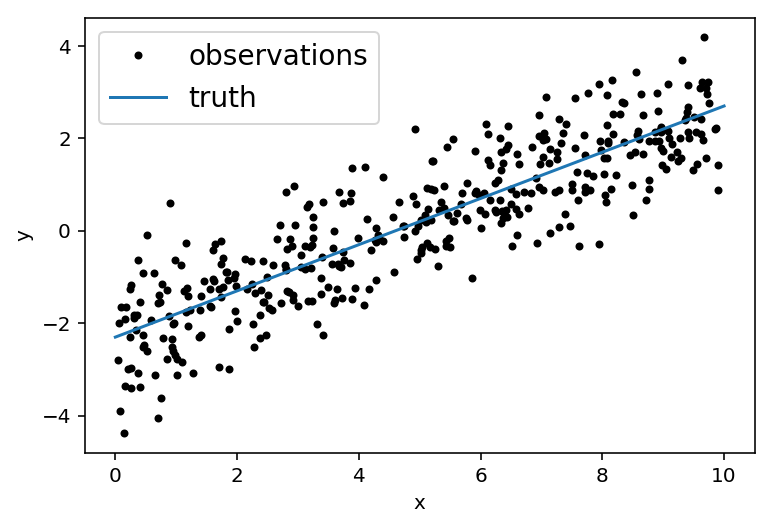

In [4]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

true_params = np.array([0.5, -2.3, -0.23])

N = 400
t = np.linspace(0, 10, 2)
x = np.random.uniform(0, 10, 400)
y = x * true_params[0] + true_params[1]
y_obs = y + np.exp(true_params[-1]) * np.random.randn(N)

plt.plot(x, y_obs, ".k", label="observations")
plt.plot(t, true_params[0]*t + true_params[1], label="truth")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(fontsize=14);

Next, define the log-likelihood function in TensorFlow:

In [5]:
m_tensor = tf.Variable(0.0, dtype=tf.float64, name="m")
b_tensor = tf.Variable(0.0, dtype=tf.float64, name="b")
logs_tensor = tf.Variable(0.0, dtype=tf.float64, name="logs")

t_tensor = tf.constant(t, dtype=tf.float64)
x_tensor = tf.constant(x, dtype=tf.float64)
y_tensor = tf.constant(y_obs, dtype=tf.float64)

mean = m_tensor * x_tensor + b_tensor
pred = m_tensor * t_tensor + b_tensor

loglike = -0.5 * tf.reduce_sum(tf.square(y_tensor - mean)) * tf.exp(-2*logs_tensor)
loglike -= 0.5 * N * logs_tensor

session.run(tf.global_variables_initializer())

And then we can fit for the maximum likelihood parameters using an optimizer from TensorFlow:

In [6]:
params = [m_tensor, b_tensor, logs_tensor]
opt = tf.contrib.opt.ScipyOptimizerInterface(-loglike, params)
opt.minimize(session)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 123.650618
  Number of iterations: 18
  Number of functions evaluations: 22


Here is the maximum likelihood solution compared to the data and the true relation:

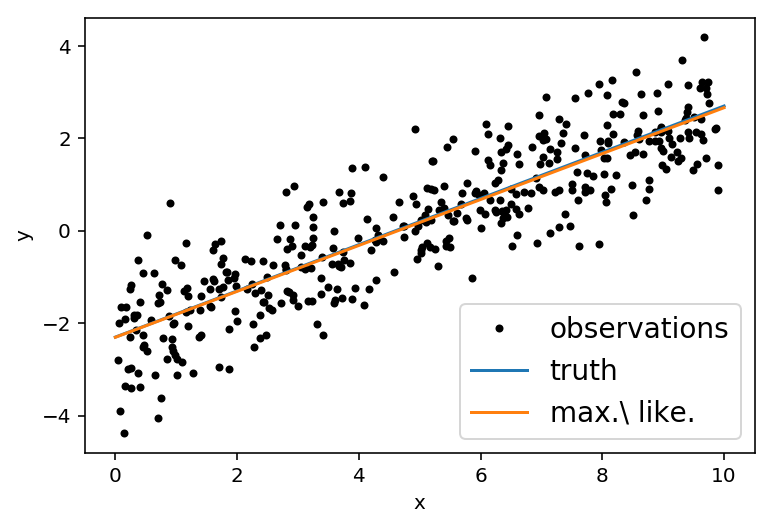

In [7]:
plt.plot(x, y_obs, ".k", label="observations")
plt.plot(t, true_params[0]*t + true_params[1], label="truth")
plt.plot(t, pred.eval(), label="max.\ like.")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(fontsize=14);

Finally, let's use PyMC3 to generate posterior samples for this model:

In [8]:
import pymc3 as pm

# First, expose the TensorFlow log likelihood implementation to Theano
# so that PyMC3 can use it
# NOTE: The "names" parameter refers to the names that will be used in
# in the PyMC3 model (see below)
tf_loglike = TensorFlowOp(loglike, [m_tensor, b_tensor, logs_tensor],
                          names=["m", "b", "logs"])

# Test the gradient
pt = session.run(tf_loglike.parameters)
# utt.verify_grad(tf_loglike, pt)

# Set up the model as usual
with pm.Model() as model:
    # Uniform priors on all the parameters
    m = pm.Uniform("m", -5, 5)
    b = pm.Uniform("b", -5, 5)
    logs = pm.Uniform("logs", -5, 5)
    
    # Define a custom "potential" to calculate the log likelihood
    pm.Potential("loglike", tf_loglike(m, b, logs))
    
    # NOTE: You *must* use "cores=1" because TensorFlow can't deal
    # with being pickled!
    trace = pm.sample(1000, tune=2000, cores=1, nuts_kwargs=dict(target_accept=0.9))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [logs, b, m]
100%|██████████| 3000/3000 [00:33<00:00, 90.47it/s]


In [9]:
model.profile(model.logpt).summary()

Function profiling
  Message: /home/star/fb90/anaconda3/lib/python3.6/site-packages/pymc3/model.py:909
  Time in 1000 calls to Function.__call__: 3.732352e-01s
  Time in Function.fn.__call__: 3.366346e-01s (90.194%)
  Time in thunks: 3.274302e-01s (87.728%)
  Total compile time: 6.208618e-01s
    Number of Apply nodes: 9
    Theano Optimizer time: 1.267161e-01s
       Theano validate time: 1.192570e-03s
    Theano Linker time (includes C, CUDA code generation/compiling): 3.242326e-02s
       Import time 2.083993e-02s
       Node make_thunk time 3.142500e-02s
           Node Elemwise{Composite{((i0 + Switch(Cast{int8}((GE(i1, i2) * LE(i1, i3))), i4, i5)) - ((i6 * scalar_softplus((-i7))) + i7))}}[(0, 1)](TensorConstant{2.302585092994046}, logs, TensorConstant{-5.0}, TensorConstant{5.0}, TensorConstant{-2.302585092994046}, TensorConstant{-inf}, TensorConstant{2.0}, logs_interval__) time 2.233362e-02s
           Node Elemwise{Composite{((i0 + Switch(Cast{int8}((GE(i1, i2) * LE(i1, i3))), i

# Implementing the same model in pure Theano

In [10]:
# Set up the model as usual
with pm.Model() as model2:
    # Uniform priors on all the parameters
    m = pm.Uniform("m", -5, 5)
    b = pm.Uniform("b", -5, 5)
    logs = pm.Uniform("logs", -5, 5)
    
    mean = m*x + b
    
    # Define a custom "potential" to calculate the log likelihood
    Y_obs = pm.Normal('Y_obs', mu=mean, sd=tt.exp(logs), observed=y)
    
    trace = pm.sample(1000, tune=2000, cores=1, nuts_kwargs=dict(target_accept=0.9))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [logs, b, m]
100%|██████████| 3000/3000 [00:17<00:00, 172.42it/s]


In [11]:
model2.profile(model2.logpt).summary()

Function profiling
  Message: /home/star/fb90/anaconda3/lib/python3.6/site-packages/pymc3/model.py:909
  Time in 1000 calls to Function.__call__: 4.482174e-02s
  Time in Function.fn.__call__: 1.595545e-02s (35.598%)
  Time in thunks: 8.830786e-03s (19.702%)
  Total compile time: 6.872456e-01s
    Number of Apply nodes: 17
    Theano Optimizer time: 3.938870e-01s
       Theano validate time: 2.299309e-03s
    Theano Linker time (includes C, CUDA code generation/compiling): 1.600580e-01s
       Import time 1.271236e-01s
       Node make_thunk time 1.583765e-01s
           Node Elemwise{Composite{(i0 * scalar_sigmoid(i1))}}(TensorConstant{10.0}, b_interval__) time 3.343201e-02s
           Node Elemwise{Composite{((i0 + Switch(Cast{int8}((GE(i1, i2) * LE(i1, i3))), i4, i5)) - ((i6 * scalar_softplus((-i7))) + i7))}}(TensorConstant{2.302585092994046}, logs, TensorConstant{-5.0}, TensorConstant{5.0}, TensorConstant{-2.302585092994046}, TensorConstant{-inf}, TensorConstant{2.0}, logs_interval_